In [1]:
%load_ext autoreload
%autoreload 2

import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#IMPORTANT: REPLACE WITH YOUR PATH TO THE RULE-VETTING GITHUB
repo_path = '/users/jbbutler129/Google Drive (butlerj@berkeley.edu)/Classes/215A/final_project/rule-vetting/'

sys.path.insert(1, repo_path)

import rulevetting.api.viz as viz
from rulevetting.projects.tbi_pecarn.dataset import Dataset

outcome_def = 'outcome'  # output
%matplotlib inline
%load_ext autoreload
%autoreload 2


/opt/anaconda3/lib/python3.8/site-packages/redis/connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading the TBI Data

In [41]:
# couldn't figure out how to do this, so I'm going to just load up the csvs on my own

#path = '/users/jbbutler129/Google Drive (butlerj@berkeley.edu)/Classes/215A/rule-vetting/rulevetting/projects/tbi_pecarn'
#df_train, df_tune, _ = Dataset().get_data(load_csvs=True, data_path = path)



In [2]:
# this is me loading up the main CSV on my own
tbi_df = pd.read_csv(repo_path + '/data/tbi_pecarn/raw/TBI PUD 10-08-2013.csv')

### Note that in this data, there are 43339 evaluable patients, meaning in Figure 1 of the paper, we are at the part of the flowchart where we haven't yet removed patients with GCS scores 3 - 13, and haven't removed the patients missing the binary outcome (but that's only 18 people so maybe not a big deal?)

# Feature Examination

Looking at the features, we see many variables a probably have nothing to do with TBIs
(employee type, certification, etc.)
Some of these also have overlapping information, so let's try to get a subset of these predictors and then look at the correlations


In [7]:
features = tbi_df.keys().tolist()
features

['PatNum',
 'EmplType',
 'Certification',
 'InjuryMech',
 'High_impact_InjSev',
 'Amnesia_verb',
 'LOCSeparate',
 'LocLen',
 'Seiz',
 'SeizOccur',
 'SeizLen',
 'ActNorm',
 'HA_verb',
 'HASeverity',
 'HAStart',
 'Vomit',
 'VomitNbr',
 'VomitStart',
 'VomitLast',
 'Dizzy',
 'Intubated',
 'Paralyzed',
 'Sedated',
 'GCSEye',
 'GCSVerbal',
 'GCSMotor',
 'GCSTotal',
 'GCSGroup',
 'AMS',
 'AMSAgitated',
 'AMSSleep',
 'AMSSlow',
 'AMSRepeat',
 'AMSOth',
 'SFxPalp',
 'SFxPalpDepress',
 'FontBulg',
 'SFxBas',
 'SFxBasHem',
 'SFxBasOto',
 'SFxBasPer',
 'SFxBasRet',
 'SFxBasRhi',
 'Hema',
 'HemaLoc',
 'HemaSize',
 'Clav',
 'ClavFace',
 'ClavNeck',
 'ClavFro',
 'ClavOcc',
 'ClavPar',
 'ClavTem',
 'NeuroD',
 'NeuroDMotor',
 'NeuroDSensory',
 'NeuroDCranial',
 'NeuroDReflex',
 'NeuroDOth',
 'OSI',
 'OSIExtremity',
 'OSICut',
 'OSICspine',
 'OSIFlank',
 'OSIAbdomen',
 'OSIPelvis',
 'OSIOth',
 'Drugs',
 'CTForm1',
 'IndAge',
 'IndAmnesia',
 'IndAMS',
 'IndClinSFx',
 'IndHA',
 'IndHema',
 'IndLOC',
 'In

This is me removing all of the traumatic finding variables/extraneous variables that indicate a TBI by definition

In [4]:
cols_rem = tbi_df.drop(tbi_df.columns[list(np.arange(96, 124)) + [1,2]], axis = 1)

In [33]:
tbi_df.columns[list(np.arange(96, 124)) + [1,2]]

Index(['Race', 'Observed', 'EDDisposition', 'CTDone', 'EDCT', 'PosCT',
       'Finding1', 'Finding2', 'Finding3', 'Finding4', 'Finding5', 'Finding6',
       'Finding7', 'Finding8', 'Finding9', 'Finding10', 'Finding11',
       'Finding12', 'Finding13', 'Finding14', 'Finding20', 'Finding21',
       'Finding22', 'Finding23', 'DeathTBI', 'HospHead', 'HospHeadPosCT',
       'Intub24Head', 'Neurosurgery', 'EmplType', 'Certification'],
      dtype='object')

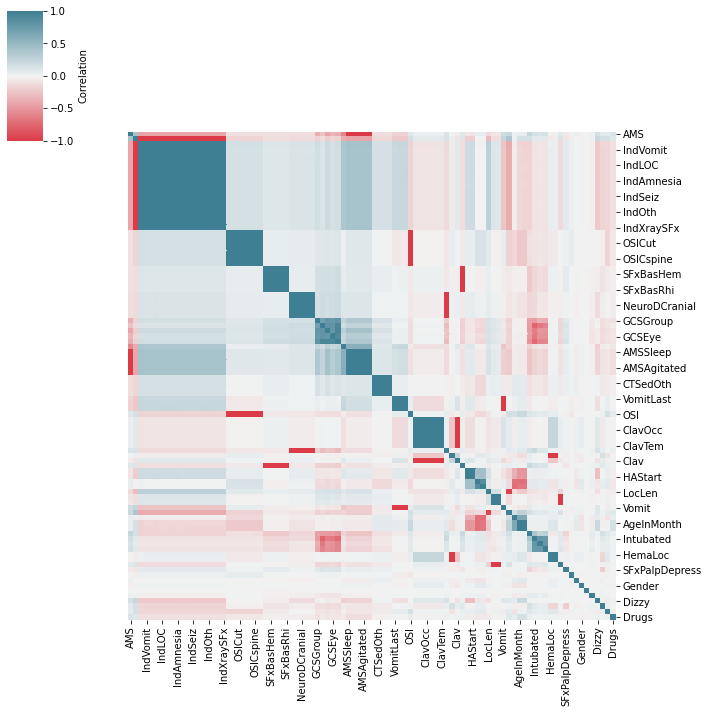

In [5]:
corrmap = sns.clustermap(cols_rem.corr(), cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
corrmap.ax_row_dendrogram.set_visible(False)
corrmap.ax_col_dendrogram.set_visible(False)


Seems like I might want to also remove all of the 'IND' variables, since those don't really indicate anything about whether or not you're going to have a TBI (reasons why you're ordering a CT scan), not really helpful for our problem because we're making classifiers to make sure individuals don't get unnecessary CT scans: an individual classified using our classifier will not have had a CT scan yet, so we wouldn't have that data anyway

In [6]:
# making a list of variables to remove
list_to_rem = []

for name in cols_rem.keys().tolist():
    
    if 'Ind' in name or 'CT' in name:
        list_to_rem.append(name)



In [7]:
# these are the variables I'm removing, since these aren't super helpful for our purposes
list_to_rem

['CTForm1',
 'IndAge',
 'IndAmnesia',
 'IndAMS',
 'IndClinSFx',
 'IndHA',
 'IndHema',
 'IndLOC',
 'IndMech',
 'IndNeuroD',
 'IndRqstMD',
 'IndRqstParent',
 'IndRqstTrauma',
 'IndSeiz',
 'IndVomit',
 'IndXraySFx',
 'IndOth',
 'CTSed',
 'CTSedAgitate',
 'CTSedAge',
 'CTSedRqst',
 'CTSedOth']

Let's take these columns and remove them!

In [8]:
cols_rem2 = cols_rem.drop(list_to_rem, axis = 1)

Now, let's replot and see what we get!

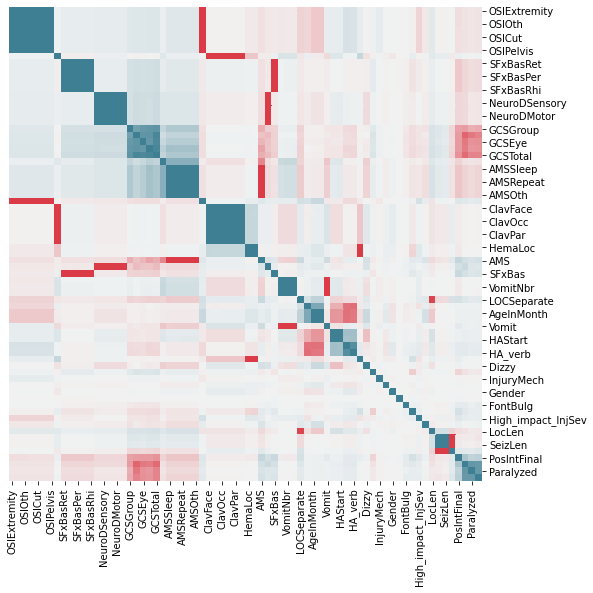

In [9]:
name = 'corrmap.png'
corrmap = sns.clustermap(cols_rem2.corr(), cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
corrmap.ax_row_dendrogram.set_visible(False)
corrmap.ax_col_dendrogram.set_visible(False)
corrmap.cax.set_visible(False)
plt.savefig(repo_path + '/rulevetting/projects/tbi_pecarn/notebooks/figs/' + name, dpi = 300)

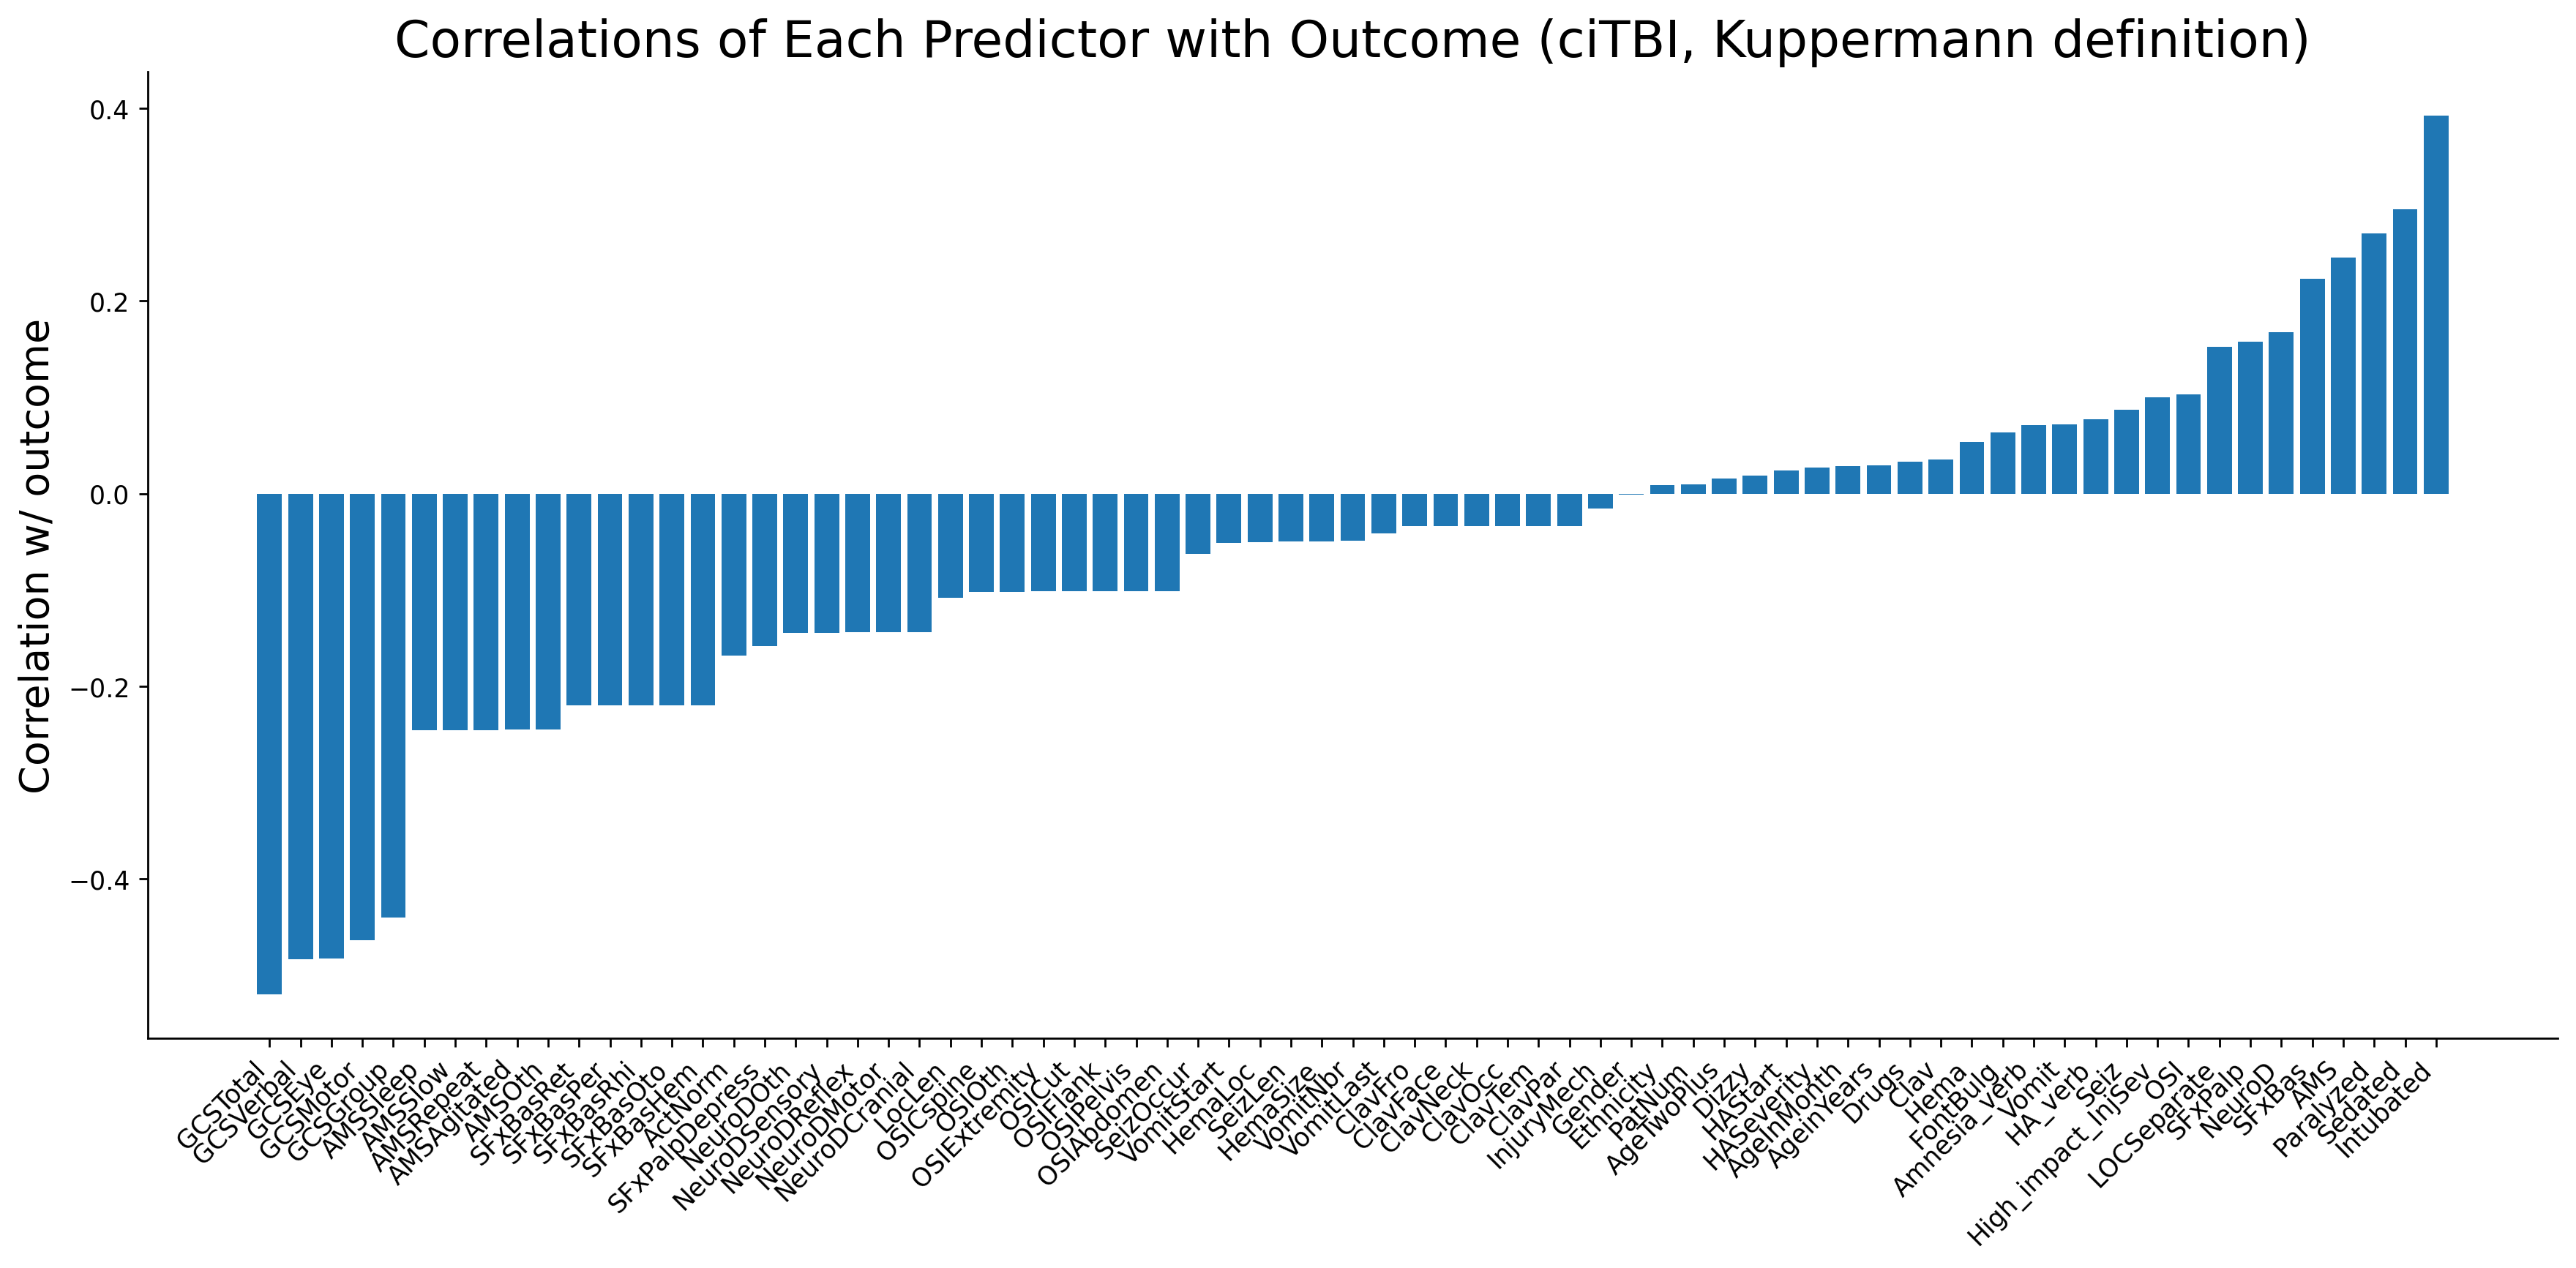

In [31]:
name = 'corr_outcomes.png'

corrs = cols_rem2.corr()

plt.figure(dpi=250, figsize=(17, 7))
vals = corrs['PosIntFinal']
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.bar(labs[:-1], vals[args][:-1])
plt.ylabel('Correlation w/ outcome', fontsize = 16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(rotation = 45, ha = 'right', fontsize = 10)
plt.title('Correlations of Each Predictor with Outcome (ciTBI, Kuppermann definition)', fontsize = 20)
plt.savefig(repo_path + '/rulevetting/projects/tbi_pecarn/notebooks/figs/' + name, dpi = 300)

It seems like the GCS Scores are highly correlated with the outcome (whether or not you have a defined TBI), Correlation does not mean causation!

Replacing the 92 values with NaN's, because I realized that this might mess up the correlation (a lot of missing values between two columns could make the correlation artificially high)

In [64]:
no_92 = cols_rem2.replace(92, np.nan)

ValueError: The condensed distance matrix must contain only finite values.

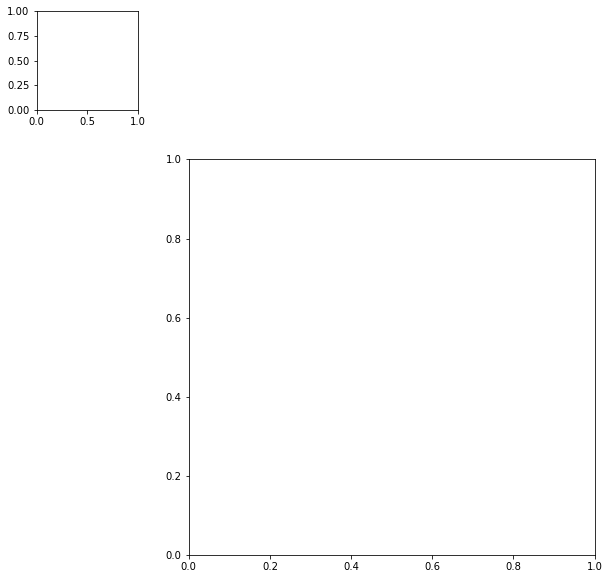

In [56]:
# replotting

name = 'corrmap.png'
corrmap = sns.clustermap(no_92.corr(), cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
corrmap.ax_row_dendrogram.set_visible(False)
corrmap.ax_col_dendrogram.set_visible(False)
corrmap.cax.set_visible(False)
#plt.savefig(repo_path + '/rulevetting/projects/tbi_pecarn/notebooks/figs/' + name, dpi = 300)

In [69]:
sum(np.isnan(np.array(no_92['OSIAbdomen'])))/len(no_92['OSIAbdomen'])

0.8947671605336528

In [76]:
# find out what proportion of each column in the nan-filled dataset are nan:
col_dict = {}

for col in list(no_92.keys()):
    
    col_dict[col] = sum(np.isnan(np.array(no_92[col])))/len(no_92[col])
    

In [78]:
col_dict.keys()

dict_keys(['PatNum', 'InjuryMech', 'High_impact_InjSev', 'Amnesia_verb', 'LOCSeparate', 'LocLen', 'Seiz', 'SeizOccur', 'SeizLen', 'ActNorm', 'HA_verb', 'HASeverity', 'HAStart', 'Vomit', 'VomitNbr', 'VomitStart', 'VomitLast', 'Dizzy', 'Intubated', 'Paralyzed', 'Sedated', 'GCSEye', 'GCSVerbal', 'GCSMotor', 'GCSTotal', 'GCSGroup', 'AMS', 'AMSAgitated', 'AMSSleep', 'AMSSlow', 'AMSRepeat', 'AMSOth', 'SFxPalp', 'SFxPalpDepress', 'FontBulg', 'SFxBas', 'SFxBasHem', 'SFxBasOto', 'SFxBasPer', 'SFxBasRet', 'SFxBasRhi', 'Hema', 'HemaLoc', 'HemaSize', 'Clav', 'ClavFace', 'ClavNeck', 'ClavFro', 'ClavOcc', 'ClavPar', 'ClavTem', 'NeuroD', 'NeuroDMotor', 'NeuroDSensory', 'NeuroDCranial', 'NeuroDReflex', 'NeuroDOth', 'OSI', 'OSIExtremity', 'OSICut', 'OSICspine', 'OSIFlank', 'OSIAbdomen', 'OSIPelvis', 'OSIOth', 'Drugs', 'AgeInMonth', 'AgeinYears', 'AgeTwoPlus', 'Gender', 'Ethnicity', 'PosIntFinal'])

In [85]:
col_names = list(col_dict.keys())
proportions = list(col_dict.values())


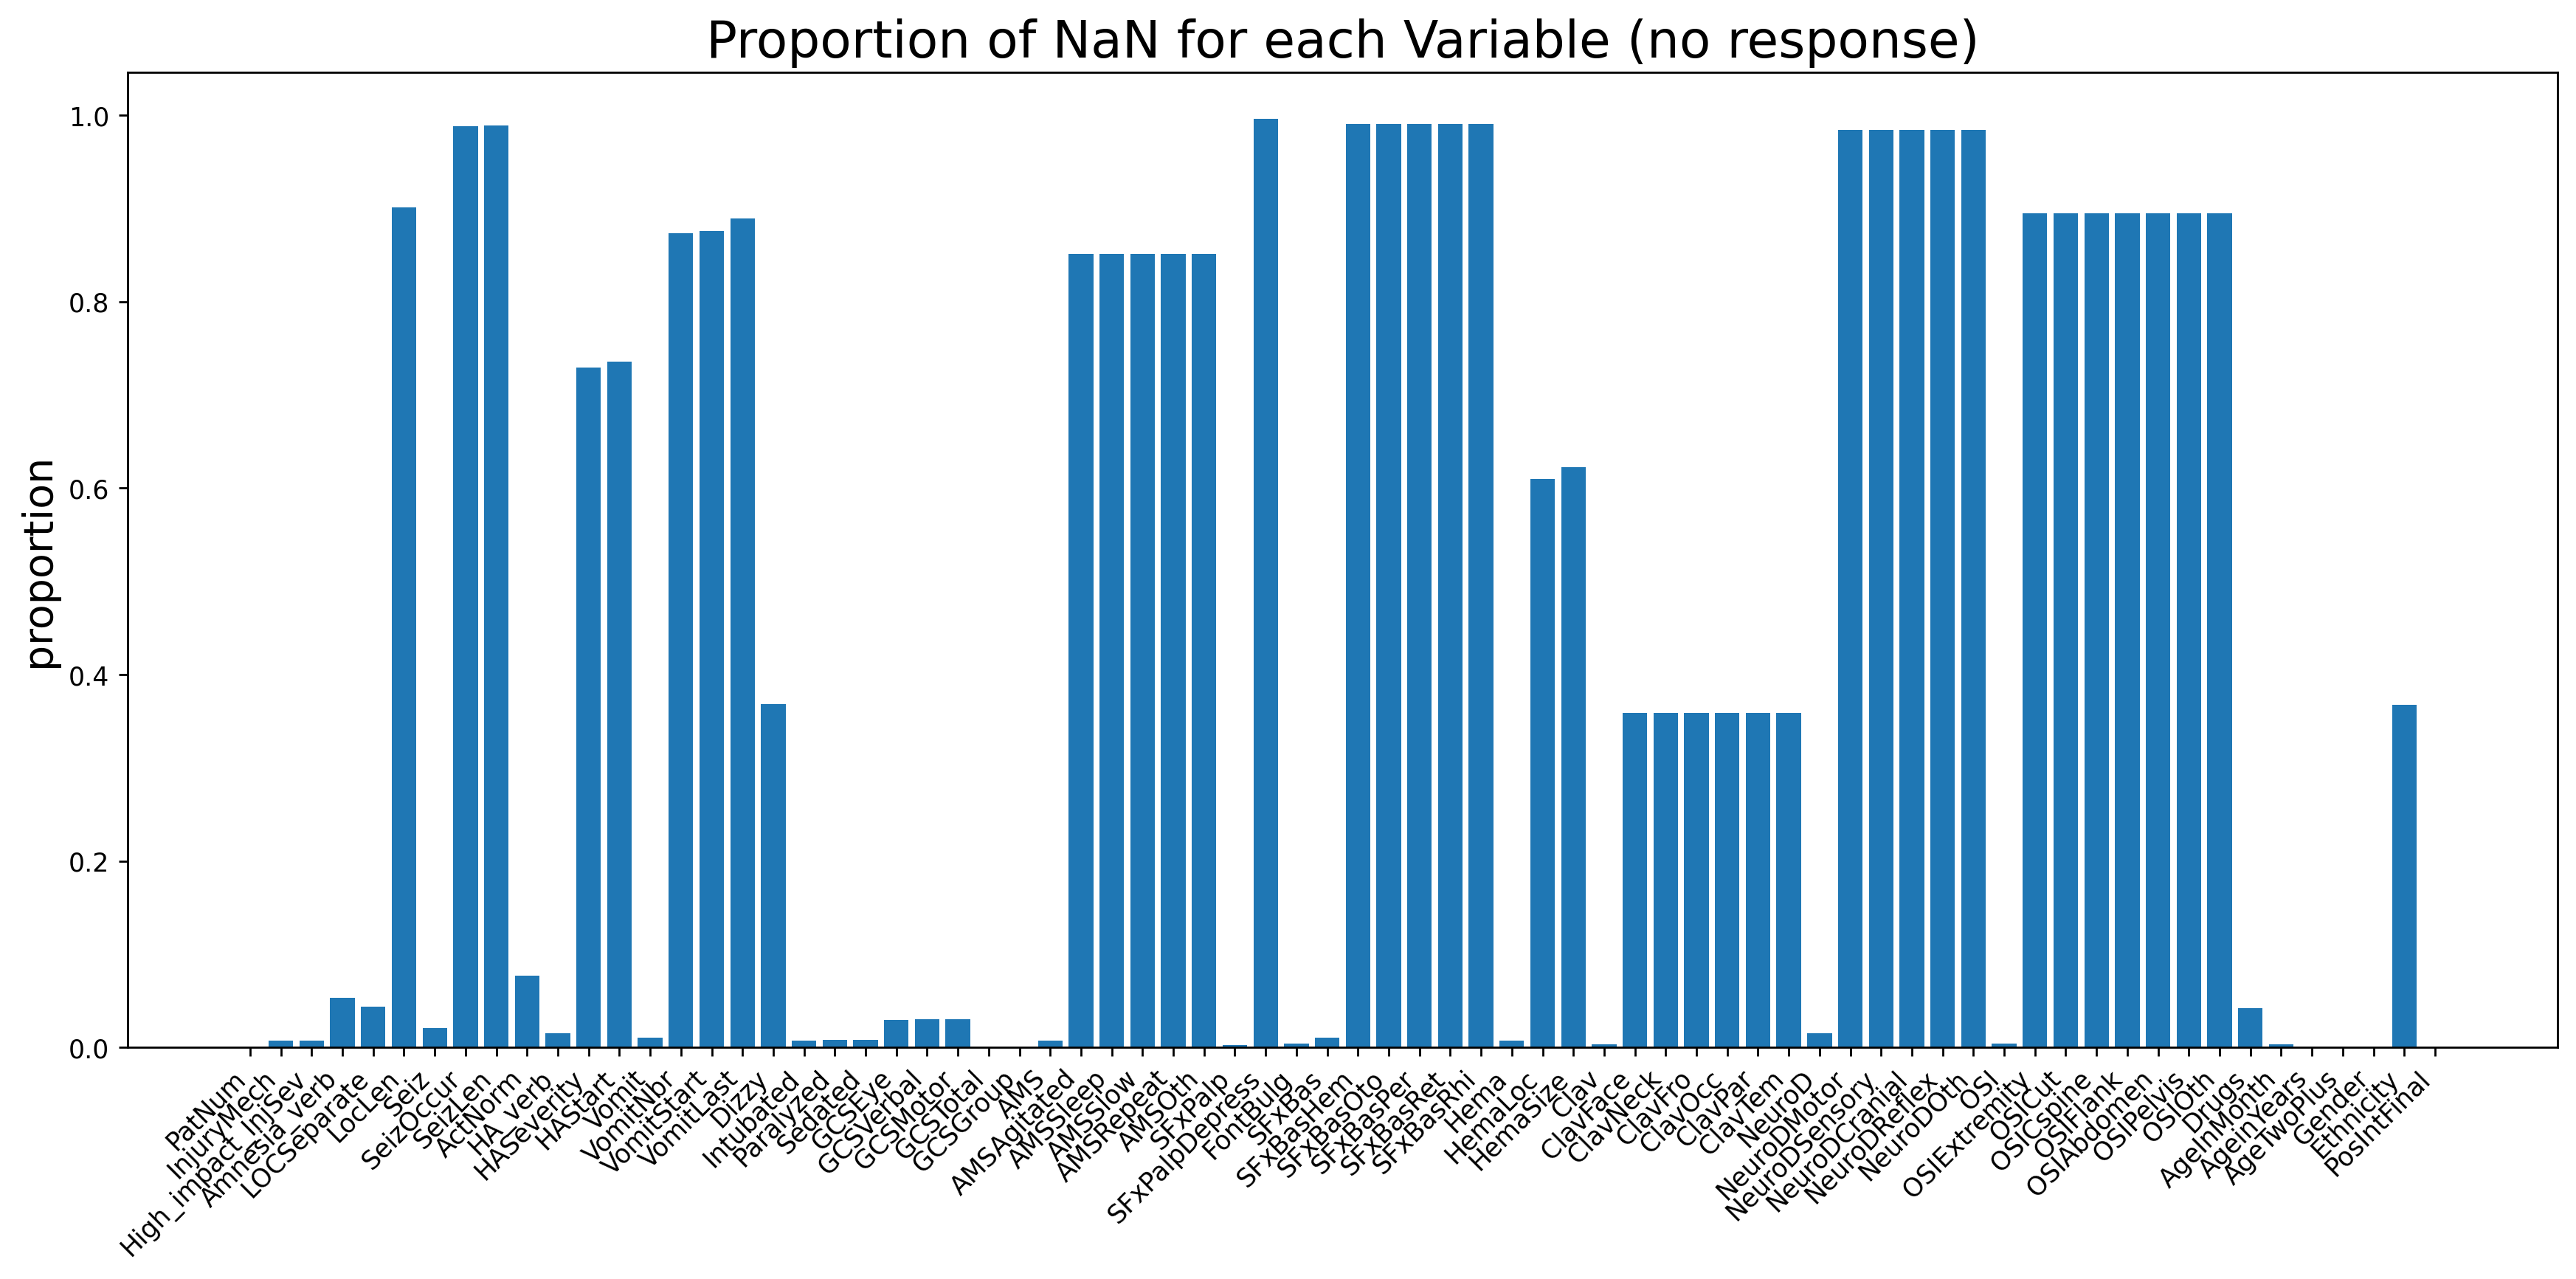

In [90]:
name = 'nan_props.png'

plt.figure(dpi=250, figsize=(17, 7))
plt.bar(col_names, proportions)
plt.ylabel('proportion', fontsize = 16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(rotation = 45, ha = 'right', fontsize = 10)
plt.title('Proportion of NaN for each Variable (no response)', fontsize = 20)
plt.savefig(repo_path + '/rulevetting/projects/tbi_pecarn/notebooks/figs/' + name, dpi = 300)

[2.304200557616535e-05,
 0.0069356436784257704,
 0.007696029862439227,
 0.05290444480287564,
 0.04359547455010484,
 0.9012419641005553,
 0.0210143090854628,
 0.98774165303348,
 0.9888015852899836,
 0.07684508859651144,
 0.015023387635659809,
 0.7289799304131431,
 0.7356160280190788,
 0.01020760847024125,
 0.8731076752920575,
 0.8757805479388926,
 0.8891218691674924,
 0.36802691306251295,
 0.007488651812253739,
 0.007742113873591558,
 0.007811239890320053,
 0.02967810318210097,
 0.029908523237862625,
 0.030185027304776606,
 0.0,
 0.0,
 0.00728127376206825,
 0.851033433950091,
 0.851033433950091,
 0.851033433950091,
 0.851033433950091,
 0.851033433950091,
 0.0023963685799211964,
 0.9961059010576281,
 0.0038480149312196134,
 0.010253692481393581,
 0.9908753657918385,
 0.9908753657918385,
 0.9908753657918385,
 0.9908753657918385,
 0.9908753657918385,
 0.007027811700730431,
 0.6099679716122491,
 0.622203276573193,
 0.003156754763934653,
 0.3590174888822323,
 0.3590174888822323,
 0.359017488